In [1]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from scipy.stats import bootstrap

D:\Anaconda3\envs\THESIS\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
# Read the main dataset
file_path = r'D:/THESIS/__UNL MS Thesis (MAIN)__/3 - Obtain Vertical Profiles/5-22_NearInflowParameters.csv'
df = pd.read_csv(file_path)

#file_path = r'D:/THESIS/__UNL MS Thesis (MAIN)__/3 - Obtain Vertical Profiles/30km_Params.csv'
#df = pd.read_csv(file_path)

# Read the PlotList.xlsx file
plot_list_path = r'D:/THESIS/__UNL MS Thesis (MAIN)__/4 - Visualize Statistics on Vertical Profiles/PlotList.xlsx'
plot_list_df = pd.read_excel(plot_list_path)

# Read the Thompson2003Params.xlsx file
thompson_path = r'D:/THESIS/__UNL MS Thesis (MAIN)__/4 - Visualize Statistics on Vertical Profiles/Thompson2003Params.xlsx'
thompson_data = pd.read_excel(thompson_path, sheet_name=None)

# Extract NONTOR and SIGTOR percentiles
nontor = thompson_data["NONTOR"]  # Load the NONTOR sheet as a DataFrame
sigtor = thompson_data["SIGTOR"]  # Load the SIGTOR sheet as a DataFrame

# Transpose the data so parameters become rows for easy lookup
nontor = nontor.set_index("Percentile")
sigtor = sigtor.set_index("Percentile")

# Exclude metadata columns
metadata_columns = [
    'StormID', 'Profile_Number', 'Time', 'Watch', 'Grouping', 'Radar',
    'Lat', 'Lon', 'Type', 'Discrete', 'Supercell', 'LeftSplit',
    'Severe30', 'ConfirmedTor30', 'Profile', 'MaxProfiles', 'Daylight',
    'SupercellAny', 'SevereAny', 'TorAny', 'Start', 'End', 'Life (in mins)',
    'Demise', 'Ini_Lat', 'Ini_Lon', 'cenlat', 'cenlon', 'ModelLat',
    'ModelLon', 'Prof_QC_issue_(bool)'
]
parameters = [col for col in df.columns if col not in metadata_columns]

In [5]:
#MANN WHITNEY U
# Save plots in Box_Plots directory
output_dir = r'D:/THESIS/__UNL MS Thesis (MAIN)__/4 - Visualize Statistics on Vertical Profiles/Box_Plots_MWU'
#output_dir = r'D:/THESIS/__UNL MS Thesis (MAIN)__/4 - Visualize Statistics on Vertical Profiles/Box_Plots_MWU_30'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [6]:
# Function to create two-panel plots
def create_two_panel_plot(param, fig_name):
    # Create figure and subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharey=True)
    fig.subplots_adjust(hspace=0.3, top=0.925, bottom=0.25, left=0.1, right=0.98)

    # Define group order and colors
    group_colors = {"WWS": "#56B4E9", "EWS": "#D55E00", "BND": "#009E73"}
    pale_group_colors = {"WWS": "#cce5ff", "EWS": "#ffcccc", "BND": "#d6f5d6"}
    group_order = ["WWS", "EWS", "BND"]

    # Get plot metadata
    plot_meta = plot_list_df.loc[plot_list_df["Parameter"] == param].iloc[0]
    title = plot_meta["Title"]
    label = plot_meta["Label"]
    ymin, ymax = plot_meta["Min"], plot_meta["Max"]

    # Set the title for the plot
    fig.suptitle(title, fontsize=16, fontweight="bold")

    for ax, hours in zip(axes, [hours_top, hours_bottom]):
        x_positions = []
        x_labels = []
        current_x = 1
        hour_positions = []

        for hour in hours:
            group_data = {}
            group_x_positions = []

            # Plot boxplots for the three groups (OPW, OPE, BND)
            for group in group_order:
                group_data[group] = df[(df["Time"] == hour) & (df["Grouping"] == group)][param].dropna()
                supercell_data = df[(df["Time"] == hour) & (df["Grouping"] == group) & (df["Supercell"] == "Y")][param].dropna()

                n_values = len(group_data[group])
                sup_values = len(supercell_data)

                if not group_data[group].empty:
                    # Calculate boxplot statistics for main group
                    q10, q25, median, q75, q90 = (np.percentile(group_data[group], p) for p in (10, 25, 50, 75, 90))

                    # Plot IQR box and borders for the main group
                    ax.add_patch(plt.Rectangle((current_x - 0.3, q25), 0.6, q75 - q25, color=group_colors[group], alpha=0.7))
                    ax.add_patch(plt.Rectangle((current_x - 0.3, q25), 0.6, q75 - q25, edgecolor="black", facecolor="none"))
                    ax.plot([current_x - 0.3, current_x + 0.3], [median, median], color="black", linewidth=2)

                    # Whiskers and outliers
                    ax.plot([current_x, current_x], [q10, q25], color="black", linewidth=1.0)
                    ax.plot([current_x, current_x], [q75, q90], color="black", linewidth=1.0)
                    ax.scatter([current_x] * len(group_data[group][(group_data[group] < q10) | (group_data[group] > q90)]),
                               group_data[group][(group_data[group] < q10) | (group_data[group] > q90)],
                               color="black", s=5)

                if not supercell_data.empty:
                    # Calculate boxplot statistics for supercell data
                    q10_sc, q25_sc, median_sc, q75_sc, q90_sc = (np.percentile(supercell_data, p) for p in (10, 25, 50, 75, 90))

                    # Plot IQR box and borders for the supercell group
                    ax.add_patch(
                        plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, color=pale_group_colors[group], alpha=1.0)
                    )
                    ax.add_patch(
                        plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, edgecolor="black", facecolor="none")
                    )
                    ax.plot([current_x - 0.1, current_x + 0.1], [median_sc, median_sc], color="black", linewidth=1.0)

                # Add group label with n-values
                x_labels.append(f"{group}\n n={n_values}({sup_values})")
                x_positions.append(current_x)
                group_x_positions.append(current_x)
                current_x += 1

            hour_positions.append(current_x - 0.5)
            
            # Perform Mann-Whitney U Test for adjacent groups
            for j in range(len(group_x_positions) - 1):
                group_1_data = df[(df["Time"] == hour) & (df["Grouping"] == group_order[j])][param].dropna()
                group_2_data = df[(df["Time"] == hour) & (df["Grouping"] == group_order[j + 1])][param].dropna()

                if not group_1_data.empty and not group_2_data.empty:
                    stat, p_value = mannwhitneyu(group_1_data, group_2_data, alternative="two-sided")

                    # Add stippling for significant p-values
                    if p_value < 0.05:
                        ax.fill_between([group_x_positions[j] - 0.3, group_x_positions[j + 1] + 0.3],
                            ymin, ymax, color="gray", alpha=0.3, zorder=0)

                    # Add p-value text
                    x_center = (group_x_positions[j] + group_x_positions[j + 1]) / 2
                    y_position = ymax - 0.07 * (ymax - ymin)
                    ax.text(x_center, y_position, f"$\\mathit{{p}}$ = {p_value:.2f}",
                            fontsize=8, ha="center", color="black", zorder=15)

            # Add Thompson boxplots (NONTOR and SIGTOR)
            if param in nontor.columns and param in sigtor.columns:
                group_center_x = (group_x_positions[0] + group_x_positions[-1]) / 2

                # NONTOR
                nontor_x = group_center_x - 1.4
                q10, q25, median, q75, q90 = nontor.loc[[10, 25, 50, 75, 90], param]
                box_width = 0.1
                ax.plot([nontor_x, nontor_x], [q10, q90], color="gray", linewidth=1.0, zorder=2)
                ax.add_patch(
                    plt.Rectangle((nontor_x - box_width / 2, q25), box_width, q75 - q25, color="gray", alpha=1.0, zorder=2)
                )

                # SIGTOR
                sigtor_x = group_center_x + 1.4
                q10, q25, median, q75, q90 = sigtor.loc[[10, 25, 50, 75, 90], param]
                ax.plot([sigtor_x, sigtor_x], [q10, q90], color="black", linewidth=1.0, zorder=2)
                ax.add_patch(
                    plt.Rectangle((sigtor_x - box_width / 2, q25), box_width, q75 - q25, color="black", alpha=1.0, zorder=2)
                )
            
            # Define label positions and labels for each subplot
            hour_label_positions_subplot1 = [2.0, 5.0, 8.0, 11.0]
            hour_labels_subplot1 = ["20", "21", "22", "23"]

            hour_label_positions_subplot2 = [2.0, 5.0, 8.0, 11.0]
            hour_labels_subplot2 = ["00", "01", "02", "03"]

            # Add hour labels to the first subplot
            for x_pos, hour_label in zip(hour_label_positions_subplot1, hour_labels_subplot1):
                y_position_hour = ymax + 0.015 * (ymax - ymin)  # Position above the plot for subplot 1
                axes[0].text(
                    x_pos,
                    y_position_hour,
                    hour_label,
                    fontsize=10,
                    ha="center",
                    va="center",
                    bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                    zorder=15,
                )

            # Add hour labels to the second subplot
            for x_pos, hour_label in zip(hour_label_positions_subplot2, hour_labels_subplot2):
                y_position_hour = ymax + 0.015 * (ymax - ymin)  # Position above the plot for subplot 2
                axes[1].text(
                    x_pos,
                    y_position_hour,
                    hour_label,
                    fontsize=10,
                    ha="center",
                    va="center",
                    bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                    zorder=15,
                )
    
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, fontsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.set_ylim(ymin, ymax)

        # Add solid vertical lines dividing hours
        for pos in hour_positions[:-1]:
            ax.axvline(pos, color="black", linewidth=2)
            
        min_x = min(x_positions) - 0.5  # Add a small margin for padding
        max_x = max(x_positions) + 0.5
        ax.set_xlim(min_x, max_x)

    axes[0].set_ylabel(label, fontsize=10)
    axes[1].set_ylabel(label, fontsize=10)

    # Save the figure
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.close()

Creating plot 1/322: sbLCL
Creating plot 2/322: mlLCL
Creating plot 3/322: muLCL
Creating plot 4/322: sbLFC
Creating plot 5/322: mlLFC
Creating plot 6/322: muLFC
Creating plot 7/322: sb_LFC_LCL_diff
Creating plot 8/322: ml_LFC_LCL_diff
Creating plot 9/322: mu_LFC_LCL_diff
Creating plot 10/322: pbl_top
Creating plot 11/322: EIL_depth
Creating plot 12/322: EIL_PBL_hgtdiff
Creating plot 13/322: sbMaxOmegaH
Creating plot 14/322: mlMaxOmegaH
Creating plot 15/322: muMaxOmegaH
Creating plot 16/322: sbHLFC
Creating plot 17/322: mlHLFC
Creating plot 18/322: muHLFC
Creating plot 19/322: deltaZstar
Creating plot 20/322: sbMaxOmega
Creating plot 21/322: mlMaxOmega
Creating plot 22/322: muMaxOmega
Creating plot 23/322: sbSCconv
Creating plot 24/322: mlSCconv
Creating plot 25/322: muSCconv
Creating plot 26/322: sbPLconv
Creating plot 27/322: mlPLconv
Creating plot 28/322: muPLconv
Creating plot 29/322: sfc1kmLapse
Creating plot 30/322: sfc2kmLapse
Creating plot 31/322: sfc3kmLapse
Creating plot 32/3

Creating plot 234/322: mlCIN_2_4km
Creating plot 235/322: mlCIN_2_5km
Creating plot 236/322: mlCIN_2_6km
Creating plot 237/322: muCIN_2_3km
Creating plot 238/322: muCIN_2_4km
Creating plot 239/322: muCIN_2_5km
Creating plot 240/322: muCIN_2_6km
Creating plot 241/322: sfc500mSRH
Creating plot 242/322: sfc1kmSRH
Creating plot 243/322: sfc3kmSRH
Creating plot 244/322: ESRH
Creating plot 245/322: 0_500_m_BWD
Creating plot 246/322: 0_1_km_BWD
Creating plot 247/322: 0_2_km_BWD
Creating plot 248/322: 0_3_km_BWD
Creating plot 249/322: 0_5_km_BWD
Creating plot 250/322: 0_6_km_BWD



KeyboardInterrupt



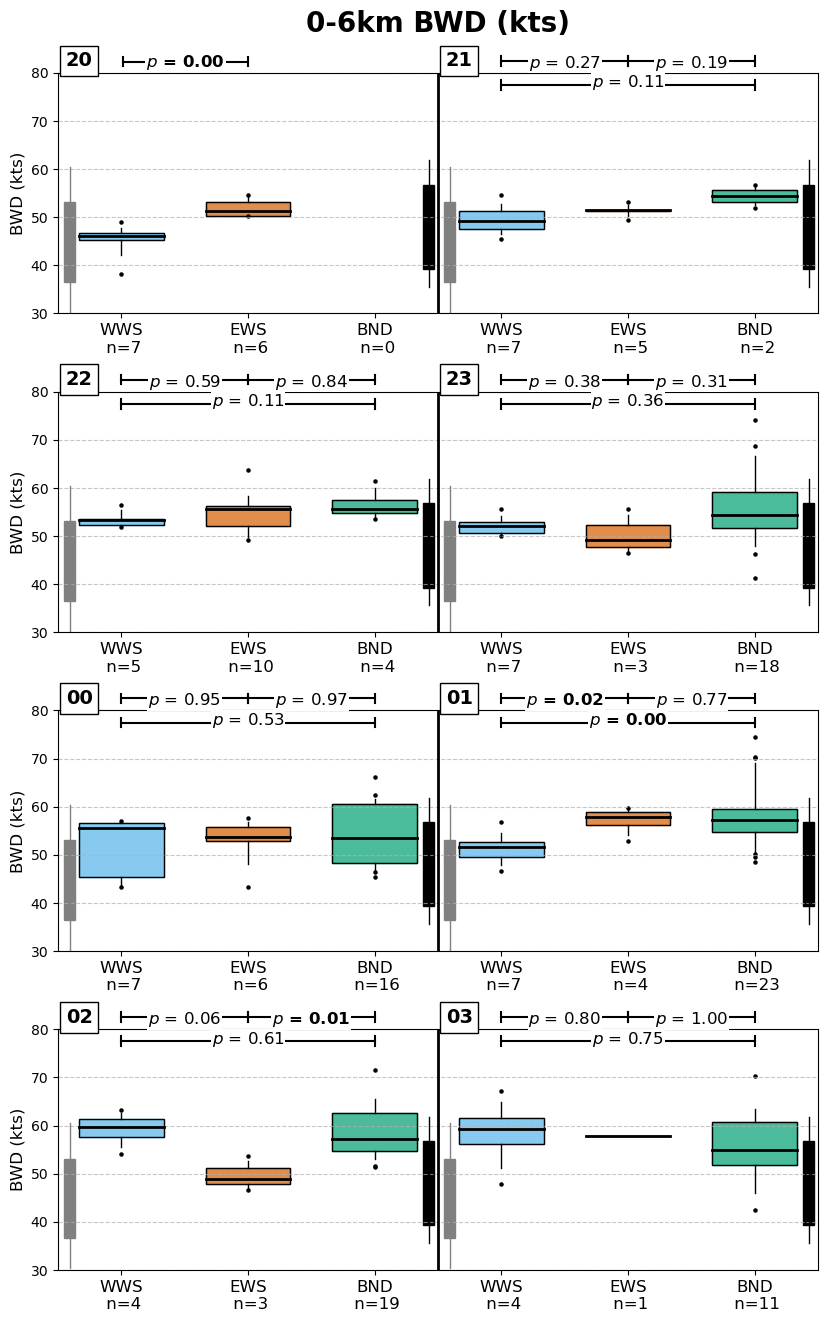

In [8]:
def create_box_whisker_plot(param, fig_name):
    # Create figure and subplots with 4 rows and 1 column (each row contains two hours)
    fig, axes = plt.subplots(4, 1, figsize=(10, 14), sharey=True)  # Adjusted size
    fig.subplots_adjust(hspace=0.325, top=0.935, bottom=0.08, left=0.12, right=0.88)  # Reduced left/right margins
    
    # Define group order and colors
    group_colors = {"WWS": "#56B4E9", "EWS": "#D55E00", "BND": "#009E73"}
    pale_group_colors = {"WWS": "#cce5ff", "EWS": "#ffcccc", "BND": "#d6f5d6"}
    group_order = ["WWS", "EWS", "BND"]

    # Get plot metadata
    plot_meta = plot_list_df.loc[plot_list_df["Parameter"] == param].iloc[0]
    title = plot_meta["Title"]
    label = plot_meta["Label"]
    ymin, ymax = plot_meta["Min"], plot_meta["Max"]

    # Define pairs of hours for each row
    hours_list = [(20, 21), (22, 23), (0, 1), (2, 3)]

    # Set the title for the entire figure
    fig.suptitle(title, fontsize=20, fontweight="bold")

    # Loop through rows and pairs of hours
    for row_idx, (ax, (hour1, hour2)) in enumerate(zip(axes, hours_list)):
        x_positions = []
        x_labels = []
        current_x = 1
        group_x_positions = []

        # Loop through two hours in each row
        for hour in (hour1, hour2):
            for group in group_order:
                #print(group)
                #print(group_order)
                group_data = df[(df["Time"] == hour) & (df["Grouping"] == group)][param].dropna()
                #supercell_data = df[(df["Time"] == hour) & (df["Grouping"] == group) & (df["Supercell"] == "Y")][param].dropna()

                n_values = len(group_data)
                #sup_values = len(supercell_data)

                if not group_data.empty:
                    # Calculate boxplot statistics
                    q10, q25, median, q75, q90 = (np.percentile(group_data, p) for p in (10, 25, 50, 75, 90))

                    # Plot main group boxplot
                    ax.add_patch(plt.Rectangle((current_x - 0.2, q25), 0.4, q75 - q25, color=group_colors[group], alpha=0.7))
                    ax.add_patch(plt.Rectangle((current_x - 0.2, q25), 0.4, q75 - q25, edgecolor="black", facecolor="none"))
                    ax.plot([current_x - 0.2, current_x + 0.2], [median, median], color="black", linewidth=2)
                    ax.plot([current_x, current_x], [q10, q25], color="black", linewidth=1.0)
                    ax.plot([current_x, current_x], [q75, q90], color="black", linewidth=1.0)
                    ax.scatter([current_x] * len(group_data[(group_data < q10) | (group_data > q90)]),
                               group_data[(group_data < q10) | (group_data > q90)], color="black", s=5)

#                 if not supercell_data.empty:
#                     # Calculate supercell statistics
#                     q10_sc, q25_sc, median_sc, q75_sc, q90_sc = (np.percentile(supercell_data, p) for p in (10, 25, 50, 75, 90))

#                     # Plot supercell boxplot
#                     ax.add_patch(plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, color=pale_group_colors[group], alpha=1.0))
#                     ax.add_patch(plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, edgecolor="black", facecolor="none"))
#                     ax.plot([current_x - 0.1, current_x + 0.1], [median_sc, median_sc], color="black", linewidth=1.0)

                # Add group label with n-values
                #x_labels.append(f"{group}\n n={n_values}({sup_values})")
                x_labels.append(f"{group}\n n={n_values}")
                x_positions.append(current_x)
                group_x_positions.append(current_x)
                current_x += 0.6  # Tightened spacing

            # Add vertical line between hours after plotting is complete
            if len(x_positions) >= len(group_order) * 2:
                try:
                    last_hour1_pos = x_positions[len(group_order) - 1]
                    first_hour2_pos = x_positions[len(group_order)]
                    midpoint = (last_hour1_pos + first_hour2_pos) / 2
                    ax.axvline(midpoint, color="black", linewidth=2)
                except IndexError as e:
                    print(f"Error adding vertical line for hours: {hour1}, {hour2}: {e}")
            
####################
                for hour, offset in zip((hour1, hour2), (0, len(group_order))):
                    data_opw = df[(df["Time"] == hour) & (df["Grouping"] == "WWS")][param].dropna()
                    data_ope = df[(df["Time"] == hour) & (df["Grouping"] == "EWS")][param].dropna()
                    data_bnd = df[(df["Time"] == hour) & (df["Grouping"] == "BND")][param].dropna()

                    y_range = ymax - ymin

                    y_border = ymax
                    y_bracket_top = y_border + 0.05 * y_range 
                    y_bracket_bottom = y_border - 0.05 * y_range 

                    text_offset = 0.03 * y_range

                    def draw_bracket(ax, x1, x2, p_value, y_bracket, is_bottom=False):
                        """Draws a statistical significance bracket with vertical ticks and centered p-value."""

                        y_text = y_bracket - text_offset if is_bottom else y_bracket + text_offset

                        midpoint = (x1 + x2) / 2
                        padding = 0.1  
                        left_segment = [x1, midpoint - padding]
                        right_segment = [midpoint + padding, x2]

                        ax.plot(left_segment, [y_bracket, y_bracket], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)
                        ax.plot(right_segment, [y_bracket, y_bracket], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)

                        tick_height = 0.02 * y_range 
                        ax.plot([x1, x1], [y_bracket + tick_height, y_bracket - tick_height], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)
                        ax.plot([x2, x2], [y_bracket + tick_height, y_bracket - tick_height], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)

                        ax.text(midpoint, y_text, f"$\\mathit{{p}}$ = {p_value:.2f}", 
                                fontsize=12, ha="center", va="bottom" if is_bottom else "top",
                                color="black", zorder=15, fontweight="bold" if p_value < 0.05 else "normal",
                                transform=ax.transData,
                                bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.05'))
                        
                    # **Pairwise comparisons**
                    if len(group_x_positions) >= 2:
                        if not data_opw.empty and not data_ope.empty:
                            stat_opw_ope, p_value_opw_ope = mannwhitneyu(data_opw, data_ope, alternative="two-sided")
                            try:
                                if hour == 20:
                                    # Get left boundary of subplot
                                    ax_left, ax_right = ax.get_position().x0, ax.get_position().x1

                                    # Position relative to subplot boundary
                                    forced_bracket_y_20z = ax.get_position().y1 + 0.008  # Slightly above the subplot
                                    forced_text_y_20z = forced_bracket_y_20z - 0.007  # Text above the bracket

                                    # Adjust x positioning in left subplot
                                    x1, x2 = ax_left + 0.065, ax_left + 0.19  # Position horizontally within the left panel

                                    ax.plot([x1, x2], [forced_bracket_y_20z, forced_bracket_y_20z], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)

                                    #Vertical ticks
                                    tick_height = 0.003  
                                    ax.plot([x1, x1], [forced_bracket_y_20z + tick_height, forced_bracket_y_20z - tick_height], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)
                                    ax.plot([x2, x2], [forced_bracket_y_20z + tick_height, forced_bracket_y_20z - tick_height], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)

                                    ax.text((x1 + x2) / 2, forced_text_y_20z,  
                                            f"$\\mathit{{p}}$ = {p_value_opw_ope:.2f}",
                                            fontsize=12, ha="center", va="bottom",
                                            color="black", zorder=15, fontweight="bold" if p_value_opw_ope < 0.05 else "normal",
                                            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.05'),
                                            transform=fig.transFigure)

                                else:
                                    draw_bracket(ax, group_x_positions[offset], group_x_positions[offset + 1], 
                                                 p_value_opw_ope, y_bracket_top, is_bottom=False)
                            except IndexError:
                                pass

                    if len(group_x_positions) >= 3:
                        if not data_ope.empty and not data_bnd.empty:
                            stat_ope_bnd, p_value_ope_bnd = mannwhitneyu(data_ope, data_bnd, alternative="two-sided")
                            try:
                                draw_bracket(ax, group_x_positions[offset + 1], group_x_positions[offset + 2], 
                                             p_value_ope_bnd, y_bracket_top, is_bottom=False)
                            except IndexError:
                                pass

                        if not data_opw.empty and not data_bnd.empty:
                            stat_opw_bnd, p_value_opw_bnd = mannwhitneyu(data_opw, data_bnd, alternative="two-sided")
                            try:
                                draw_bracket(ax, group_x_positions[offset], group_x_positions[offset + 2], 
                                             p_value_opw_bnd, y_bracket_bottom, is_bottom=True)
                            except IndexError:
                                pass

        hour_label_positions = [0.8, 2.6]
        hour_labels = [f"{hour1:02d}", f"{hour2:02d}"]

        for x_pos, hour_label in zip(hour_label_positions, hour_labels):
            y_position_hour = ymax + 0.05 * (ymax - ymin)  
            ax.text(
                x_pos,
                y_position_hour,
                hour_label,
                fontsize=14,
                fontweight="bold",
                ha="center",
                va="center",
                bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                zorder=15,)

        # Add Thompson boxplots
        if param in nontor.columns and param in sigtor.columns:
            for hour_idx, hour in enumerate([hour1, hour2]):
                hour_group_x_positions = x_positions[hour_idx * len(group_order):(hour_idx + 1) * len(group_order)]
                if not hour_group_x_positions:
                    continue

                group_center_x = (min(hour_group_x_positions) + max(hour_group_x_positions)) / 2
                nontor_x = group_center_x - 0.87
                sigtor_x = group_center_x + 0.83

                if not nontor[param].isna().all():
                    try:
                        q10, q25, median, q75, q90 = nontor.loc[[10, 25, 50, 75, 90], param]
                        ax.plot([nontor_x + 0.025, nontor_x + 0.025], [q10, q90], color="gray", linewidth=1.0)
                        ax.add_patch(plt.Rectangle((nontor_x, q25), 0.05, q75 - q25, color="gray", alpha=1.0))
                    except KeyError:
                        pass

                if not sigtor[param].isna().all():
                    try:
                        q10, q25, median, q75, q90 = sigtor.loc[[10, 25, 50, 75, 90], param]
                        ax.plot([sigtor_x + 0.025, sigtor_x + 0.025], [q10, q90], color="black", linewidth=1.0)
                        ax.add_patch(plt.Rectangle((sigtor_x, q25), 0.05, q75 - q25, color="black", alpha=1.0))
                    except KeyError:
                        pass

        # Set x-axis labels and limits
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, fontsize=12)
        ax.set_xlim(min(x_positions) - 0.3, max(x_positions) + 0.3)
        ax.set_ylim(ymin, ymax)
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        # Set Y-axis label for the entire row
        ax.set_ylabel(label, fontsize=12)

    # Save the figure
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.close()
    
for idx, param in enumerate(parameters):
    print(f"Creating plot {idx + 1}/{len(parameters)}: {param}")
    output_file = os.path.join(output_dir, f"{str(idx + 1).zfill(3)}_{param}.png").replace("\\", "/")
    create_box_whisker_plot(param, output_file)

In [11]:
# start_idx = 240  # Zero-based index; this resumes at item 294

# for idx, param in enumerate(parameters[start_idx:], start=start_idx):
#     print(f"Creating plot {idx + 1}/{len(parameters)}: {param}")
#     output_file = os.path.join(output_dir, f"{str(idx + 1).zfill(3)}_{param}.png").replace("\\", "/")
#     create_box_whisker_plot(param, output_file)

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

def compute_pval_table(df, parameters):
    """
    Compute pairwise Mann-Whitney U test p-values for three group comparisons across 7 hours.

    Returns:
        A pandas DataFrame with 21 columns: 7 for each pairwise comparison.
    """
    hours = list(range(20, 24)) + list(range(0, 4))
    comparisons = [
        ("WWS", "EWS"),
        ("EWS", "BND"),
        ("WWS", "BND"),
    ]

    col_names = [
        f"{g1}_vs_{g2}_{h:02d}UTC"
        for (g1, g2) in comparisons
        for h in hours
    ]

    result = pd.DataFrame(index=parameters, columns=col_names, dtype=float)

    for param in parameters:
        for (g1, g2) in comparisons:
            for h in hours:
                data1 = df[(df["Grouping"] == g1) & (df["Time"] == h)][param].dropna()
                data2 = df[(df["Grouping"] == g2) & (df["Time"] == h)][param].dropna()

                col = f"{g1}_vs_{g2}_{h:02d}UTC"

                if len(data1) > 0 and len(data2) > 0:
                    try:
                        _, p_val = mannwhitneyu(data1, data2, alternative="two-sided")
                        result.at[param, col] = p_val
                    except Exception as e:
                        print(f"Error computing p-value for {col}: {e}")
                        result.at[param, col] = np.nan
                else:
                    print(f"No data for {col} ({g1}: {len(data1)}, {g2}: {len(data2)})")
                    result.at[param, col] = np.nan

    return result

In [19]:
# Create the full 21-column table
pval_table = compute_pairwise_pvals_by_hour(df, parameters)

# Save to CSV
pval_table.to_csv("pairwise_pvals_by_hour.csv")

# Display the first few rows
pval_table.head()

,WWS_vs_EWS_20UTC,WWS_vs_EWS_21UTC,WWS_vs_EWS_22UTC,WWS_vs_EWS_23UTC,WWS_vs_EWS_00UTC,WWS_vs_EWS_01UTC,WWS_vs_EWS_02UTC,WWS_vs_EWS_03UTC,EWS_vs_BND_20UTC,EWS_vs_BND_21UTC,...,EWS_vs_BND_02UTC,EWS_vs_BND_03UTC,WWS_vs_BND_20UTC,WWS_vs_BND_21UTC,WWS_vs_BND_22UTC,WWS_vs_BND_23UTC,WWS_vs_BND_00UTC,WWS_vs_BND_01UTC,WWS_vs_BND_02UTC,WWS_vs_BND_03UTC
sbLCL,0.101399,0.267677,0.439560,0.183333,0.004662,0.648485,0.628571,0.4,NaN,0.857143,...,0.407792,0.333333,NaN,0.888889,1.000000,0.003029,0.000057,0.000065,0.000226,0.342857
mlLCL,0.073427,0.073232,0.513487,1.000000,0.945221,0.012121,0.057143,1.0,NaN,0.857143,...,0.585714,0.500000,NaN,0.222222,0.555556,0.002347,0.014905,0.000029,0.000903,0.055678
muLCL,0.101399,0.530303,0.439560,0.116667,0.365967,0.787879,0.057143,0.4,NaN,0.190476,...,0.264935,0.166667,NaN,0.222222,1.000000,0.063928,0.451523,0.225917,0.116318,0.753114
sbLFC,0.001166,0.148990,0.859141,0.183333,0.013986,0.006061,0.057143,0.4,NaN,0.857143,...,0.338567,0.666667,NaN,0.666667,0.730159,0.422875,0.000538,0.004919,0.081105,0.017582
mlLFC,0.013986,0.017677,0.767899,0.116667,0.051282,0.787879,0.628571,0.4,NaN,0.380952,...,0.857143,1.000000,NaN,0.055556,0.904762,0.745088,0.027264,0.266108,0.906832,0.177289


In [165]:
#BOOTSTRAPPED CONFIDENCE INTERVAL
# Save plots in Box_Plots directory
output_dir = r'D:/THESIS/__UNL MS Thesis (MAIN)__/4 - Visualize Statistics on Vertical Profiles/Box_Plots_CI'
#output_dir = r'D:/THESIS/__UNL MS Thesis (MAIN)__/4 - Visualize Statistics on Vertical Profiles/Box_Plots_CI_30'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [155]:
# import numpy as np
# from scipy.stats import bootstrap

# def bootstrap_diff_ci(data1, data2, n_resamples=10000, alpha=0.05):
#     """
#     Bootstrap confidence interval for the median difference (data1 - data2)
#     using SciPy 1.10.x-safe logic.
#     """
#     data1 = np.asarray(data1)
#     data2 = np.asarray(data2)

#     if len(data1) < 2 or len(data2) < 2:
#         return np.nan, np.nan

#     # Stack data vertically into shape (2, N)
#     stacked_data = np.vstack((data1, data2))

#     def stat_func(data, axis=None):
#         # data shape: (2, N) -- we do NOT unpack
#         d1 = data[0]
#         d2 = data[1]
#         return np.median(d1) - np.median(d2)

#     try:
#         result = bootstrap(
#             data=stacked_data,
#             statistic=stat_func,
#             vectorized=False,
#             paired=False,
#             confidence_level=1 - alpha,
#             n_resamples=n_resamples,
#             method="percentile"
#         )
#         return result.confidence_interval.low, result.confidence_interval.high
#     except Exception as e:
#         print("Bootstrap failed:", e)
#         return np.nan, np.nan


In [170]:
import numpy as np
from scipy.stats import bootstrap

def bootstrap_diff_ci(data1, data2, n_resamples=10000, alpha=0.05):
    data1 = np.asarray(data1, dtype=float)
    data2 = np.asarray(data2, dtype=float)
    
    if len(data1) < 2 or len(data2) < 2:
        print(f"Too few samples: len(data1)={len(data1)}, len(data2)={len(data2)}")
        return np.nan, np.nan

    n1 = len(data1)
    n2 = len(data2)
    data_stacked = np.concatenate([data1, data2])

    def stat_func(data):
        d1 = data[:n1]
        d2 = data[n1:]
        return np.median(d1) - np.median(d2)

    try:
        result = bootstrap(
            data=(data_stacked,),
            statistic=stat_func,
            vectorized=False,
            paired=False,
            confidence_level=1 - alpha,
            n_resamples=n_resamples,
            method='BCa'
        )
        return float(result.confidence_interval.low), float(result.confidence_interval.high)
    
    except Exception as e:
        print(f"Bootstrap failed for sample sizes {n1}, {n2}")
        print("data1:", data1)
        print("data2:", data2)
        print("Bootstrap failed:", e)
        return np.nan, np.nan


In [156]:
# import numpy as np
# from scipy.stats import bootstrap

# def bootstrap_diff_ci(data1, data2, n_resamples=10000, alpha=0.05):
#     data1 = np.asarray(data1)
#     data2 = np.asarray(data2)

#     if len(data1) < 2 or len(data2) < 2:
#         return np.nan, np.nan

#     # Combine into a tuple of arrays for bootstrap input
#     def stat_func(data, axis=0):
#         d1, d2 = data
#         return np.median(d1) - np.median(d2)

#     try:
#         result = bootstrap(
#             data=(data1, data2),
#             statistic=stat_func,
#             vectorized=False,
#             paired=False,
#             confidence_level=1 - alpha,
#             n_resamples=n_resamples,
#             method="percentile"
#         )
#         return float(result.confidence_interval.low), float(result.confidence_interval.high)

#     except Exception as e:
#         print("Bootstrap failed:", e)
#         return np.nan, np.nan


In [167]:
a = np.array([1, 2, 3, 14, 5, 5, 14, 11, 1, 4])
b = np.array([5, 6, 1, 8, 19, 5, 1, 6, 17, 7])

ci_low, ci_high = bootstrap_diff_ci(a, b)
print(f"Bootstrapped CI: [{ci_low:.2f}, {ci_high:.2f}]")

Bootstrapped CI: [-12.61, 0.50]


In [171]:
# Function to create two-panel plots
def create_two_panel_plot(param, fig_name):
    # Create figure and subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharey=True)
    fig.subplots_adjust(hspace=0.3, top=0.925, bottom=0.25, left=0.1, right=0.98)

    # Define group order and colors
    group_colors = {"OPW": "blue", "OPE": "red", "BND": "green"}
    pale_group_colors = {"OPW": "#cce5ff", "OPE": "#ffcccc", "BND": "#d6f5d6"}
    group_order = ["OPW", "OPE", "BND"]

    # Get plot metadata
    plot_meta = plot_list_df.loc[plot_list_df["Parameter"] == param].iloc[0]
    title = plot_meta["Title"]
    label = plot_meta["Label"]
    ymin, ymax = plot_meta["Min"], plot_meta["Max"]

    # Set the title for the plot
    fig.suptitle(title, fontsize=16, fontweight="bold")

    for ax, hours in zip(axes, [hours_top, hours_bottom]):
        x_positions = []
        x_labels = []
        current_x = 1
        hour_positions = []

        for hour in hours:
            group_data = {}
            group_x_positions = []

            # Plot boxplots for the three groups (OPW, OPE, BND)
            for group in group_order:
                group_data[group] = df[(df["Time"] == hour) & (df["Grouping"] == group)][param].dropna()
                supercell_data = df[(df["Time"] == hour) & (df["Grouping"] == group) & (df["Supercell"] == "Y")][param].dropna()

                n_values = len(group_data[group])
                sup_values = len(supercell_data)

                if not group_data[group].empty:
                    # Calculate boxplot statistics for main group
                    q10, q25, median, q75, q90 = (np.percentile(group_data[group], p) for p in (10, 25, 50, 75, 90))

                    # Plot IQR box and borders for the main group
                    ax.add_patch(plt.Rectangle((current_x - 0.3, q25), 0.6, q75 - q25, color=group_colors[group], alpha=0.7))
                    ax.add_patch(plt.Rectangle((current_x - 0.3, q25), 0.6, q75 - q25, edgecolor="black", facecolor="none"))
                    ax.plot([current_x - 0.3, current_x + 0.3], [median, median], color="black", linewidth=2)

                    # Whiskers and outliers
                    ax.plot([current_x, current_x], [q10, q25], color="black", linewidth=1.0)
                    ax.plot([current_x, current_x], [q75, q90], color="black", linewidth=1.0)
                    ax.scatter([current_x] * len(group_data[group][(group_data[group] < q10) | (group_data[group] > q90)]),
                               group_data[group][(group_data[group] < q10) | (group_data[group] > q90)],
                               color="black", s=5)

                if not supercell_data.empty:
                    # Calculate boxplot statistics for supercell data
                    q10_sc, q25_sc, median_sc, q75_sc, q90_sc = (np.percentile(supercell_data, p) for p in (10, 25, 50, 75, 90))

                    # Plot IQR box and borders for the supercell group
                    ax.add_patch(
                        plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, color=pale_group_colors[group], alpha=1.0)
                    )
                    ax.add_patch(
                        plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, edgecolor="black", facecolor="none")
                    )
                    ax.plot([current_x - 0.1, current_x + 0.1], [median_sc, median_sc], color="black", linewidth=1.0)

                # Add group label with n-values
                x_labels.append(f"{group}\n n={n_values}({sup_values})")
                x_positions.append(current_x)
                group_x_positions.append(current_x)
                current_x += 1

            hour_positions.append(current_x - 0.5)
            
            # Perform Mann-Whitney U Test for adjacent groups
            for j in range(len(group_x_positions) - 1):
                data1 = df[(df["Time"] == hour) & (df["Grouping"] == group_order[j])][param].dropna().values
                data2 = df[(df["Time"] == hour) & (df["Grouping"] == group_order[j + 1])][param].dropna().values

                if len(data1) > 1 and len(data2) > 1:
                    ci_low, ci_high = bootstrap_diff_ci(data1, data2)
                    significant = (ci_low > 0) or (ci_high < 0)

                    # Add stippling if CI excludes zero
                    if significant:
                        ax.fill_between([group_x_positions[j] - 0.3, group_x_positions[j + 1] + 0.3],
                                        ymin, ymax, color="gray", alpha=0.3, zorder=0)

                    # Annotate CI text
                    x_center = (group_x_positions[j] + group_x_positions[j + 1]) / 2
                    y_position = ymax - 0.07 * (ymax - ymin)
                    label = f"CI: [{ci_low:.2f}, {ci_high:.2f}]"
                    text_kwargs = {
                        'fontsize': 8,
                        'ha': 'center',
                        'color': 'black',
                        'zorder': 15,
                    }

                    if significant:
                        ax.text(x_center, y_position, f"$\\mathbf{{{label}}}$", **text_kwargs)
                    else:
                        ax.text(x_center, y_position, label, **text_kwargs)
                    
            # Add Thompson boxplots (NONTOR and SIGTOR)
            if param in nontor.columns and param in sigtor.columns:
                group_center_x = (group_x_positions[0] + group_x_positions[-1]) / 2

                # NONTOR
                nontor_x = group_center_x - 1.4
                q10, q25, median, q75, q90 = nontor.loc[[10, 25, 50, 75, 90], param]
                box_width = 0.1
                ax.plot([nontor_x, nontor_x], [q10, q90], color="gray", linewidth=1.0, zorder=2)
                ax.add_patch(
                    plt.Rectangle((nontor_x - box_width / 2, q25), box_width, q75 - q25, color="gray", alpha=1.0, zorder=2)
                )

                # SIGTOR
                sigtor_x = group_center_x + 1.4
                q10, q25, median, q75, q90 = sigtor.loc[[10, 25, 50, 75, 90], param]
                ax.plot([sigtor_x, sigtor_x], [q10, q90], color="black", linewidth=1.0, zorder=2)
                ax.add_patch(
                    plt.Rectangle((sigtor_x - box_width / 2, q25), box_width, q75 - q25, color="black", alpha=1.0, zorder=2)
                )
            
            # Define label positions and labels for each subplot
            hour_label_positions_subplot1 = [2.0, 5.0, 8.0, 11.0]
            hour_labels_subplot1 = ["20", "21", "22", "23"]

            hour_label_positions_subplot2 = [2.0, 5.0, 8.0, 11.0]
            hour_labels_subplot2 = ["00", "01", "02", "03"]

            # Add hour labels to the first subplot
            for x_pos, hour_label in zip(hour_label_positions_subplot1, hour_labels_subplot1):
                y_position_hour = ymax + 0.015 * (ymax - ymin)  # Position above the plot for subplot 1
                axes[0].text(
                    x_pos,
                    y_position_hour,
                    hour_label,
                    fontsize=10,
                    ha="center",
                    va="center",
                    bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                    zorder=15,
                )

            # Add hour labels to the second subplot
            for x_pos, hour_label in zip(hour_label_positions_subplot2, hour_labels_subplot2):
                y_position_hour = ymax + 0.015 * (ymax - ymin)  # Position above the plot for subplot 2
                axes[1].text(
                    x_pos,
                    y_position_hour,
                    hour_label,
                    fontsize=10,
                    ha="center",
                    va="center",
                    bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                    zorder=15,
                )
    
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, fontsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.set_ylim(ymin, ymax)

        # Add solid vertical lines dividing hours
        for pos in hour_positions[:-1]:
            ax.axvline(pos, color="black", linewidth=2)
            
        min_x = min(x_positions) - 0.5  # Add a small margin for padding
        max_x = max(x_positions) + 0.5
        ax.set_xlim(min_x, max_x)

    axes[0].set_ylabel(label, fontsize=10)
    axes[1].set_ylabel(label, fontsize=10)

    # Save the figure
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.close()

In [172]:
def create_box_whisker_plot(param, fig_name):
    # Create figure and subplots with 4 rows and 1 column (each row contains two hours)
    fig, axes = plt.subplots(4, 1, figsize=(10, 14), sharey=True)  # Adjusted size
    fig.subplots_adjust(hspace=0.325, top=0.935, bottom=0.08, left=0.12, right=0.88)  # Reduced left/right margins

    # Define group order and colors
    group_colors = {"OPW": "blue", "OPE": "red", "BND": "green"}
    pale_group_colors = {"OPW": "#cce5ff", "OPE": "#ffcccc", "BND": "#d6f5d6"}
    group_order = ["OPW", "OPE", "BND"]

    # Get plot metadata
    plot_meta = plot_list_df.loc[plot_list_df["Parameter"] == param].iloc[0]
    title = plot_meta["Title"]
    label = plot_meta["Label"]
    ymin, ymax = plot_meta["Min"], plot_meta["Max"]

    # Define pairs of hours for each row
    hours_list = [(20, 21), (22, 23), (0, 1), (2, 3)]

    # Set the title for the entire figure
    fig.suptitle(title, fontsize=20, fontweight="bold")

    # Loop through rows and pairs of hours
    for row_idx, (ax, (hour1, hour2)) in enumerate(zip(axes, hours_list)):
        x_positions = []
        x_labels = []
        current_x = 1
        group_x_positions = []

        # Loop through two hours in each row
        for hour in (hour1, hour2):
            for group in group_order:
                #print(group)
                #print(group_order)
                group_data = df[(df["Time"] == hour) & (df["Grouping"] == group)][param].dropna()
                #supercell_data = df[(df["Time"] == hour) & (df["Grouping"] == group) & (df["Supercell"] == "Y")][param].dropna()

                n_values = len(group_data)
                #sup_values = len(supercell_data)

                if not group_data.empty:
                    # Calculate boxplot statistics
                    q10, q25, median, q75, q90 = (np.percentile(group_data, p) for p in (10, 25, 50, 75, 90))

                    # Plot main group boxplot
                    ax.add_patch(plt.Rectangle((current_x - 0.2, q25), 0.4, q75 - q25, color=group_colors[group], alpha=0.7))
                    ax.add_patch(plt.Rectangle((current_x - 0.2, q25), 0.4, q75 - q25, edgecolor="black", facecolor="none"))
                    ax.plot([current_x - 0.2, current_x + 0.2], [median, median], color="black", linewidth=2)
                    ax.plot([current_x, current_x], [q10, q25], color="black", linewidth=1.0)
                    ax.plot([current_x, current_x], [q75, q90], color="black", linewidth=1.0)
                    ax.scatter([current_x] * len(group_data[(group_data < q10) | (group_data > q90)]),
                               group_data[(group_data < q10) | (group_data > q90)], color="black", s=5)

#                 if not supercell_data.empty:
#                     # Calculate supercell statistics
#                     q10_sc, q25_sc, median_sc, q75_sc, q90_sc = (np.percentile(supercell_data, p) for p in (10, 25, 50, 75, 90))

#                     # Plot supercell boxplot
#                     ax.add_patch(plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, color=pale_group_colors[group], alpha=1.0))
#                     ax.add_patch(plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, edgecolor="black", facecolor="none"))
#                     ax.plot([current_x - 0.1, current_x + 0.1], [median_sc, median_sc], color="black", linewidth=1.0)

                # Add group label with n-values
                #x_labels.append(f"{group}\n n={n_values}({sup_values})")
                x_labels.append(f"{group}\n n={n_values}")
                x_positions.append(current_x)
                group_x_positions.append(current_x)
                current_x += 0.6  # Tightened spacing

            # Add vertical line between hours after plotting is complete
            if len(x_positions) >= len(group_order) * 2:
                try:
                    last_hour1_pos = x_positions[len(group_order) - 1]
                    first_hour2_pos = x_positions[len(group_order)]
                    midpoint = (last_hour1_pos + first_hour2_pos) / 2
                    ax.axvline(midpoint, color="black", linewidth=2)
                except IndexError as e:
                    print(f"Error adding vertical line for hours: {hour1}, {hour2}: {e}")
            
####################
                for hour, offset in zip((hour1, hour2), (0, len(group_order))):
                    data_opw = df[(df["Time"] == hour) & (df["Grouping"] == "OPW")][param].dropna()
                    data_ope = df[(df["Time"] == hour) & (df["Grouping"] == "OPE")][param].dropna()
                    data_bnd = df[(df["Time"] == hour) & (df["Grouping"] == "BND")][param].dropna()

                    y_range = ymax - ymin

                    y_border = ymax
                    y_bracket_top = y_border + 0.05 * y_range 
                    y_bracket_bottom = y_border - 0.05 * y_range 

                    text_offset = 0.03 * y_range

                    def draw_bracket(ax, x1, x2, label, y_bracket, is_bottom=False):
                        """Draws a statistical bracket with label (e.g., CI)."""
                        y_text = y_bracket - text_offset if is_bottom else y_bracket + text_offset
                        midpoint = (x1 + x2) / 2
                        padding = 0.1
                        left_segment = [x1, midpoint - padding]
                        right_segment = [midpoint + padding, x2]

                        ax.plot(left_segment, [y_bracket, y_bracket], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)
                        ax.plot(right_segment, [y_bracket, y_bracket], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)

                        tick_height = 0.02 * y_range
                        ax.plot([x1, x1], [y_bracket + tick_height, y_bracket - tick_height], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)
                        ax.plot([x2, x2], [y_bracket + tick_height, y_bracket - tick_height], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)

                        ax.text(midpoint, y_text, label,
                                fontsize=10, ha="center", va="bottom" if is_bottom else "top",
                                color="black", zorder=15, transform=ax.transData,
                                bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.05'))
                        
                    # **Pairwise comparisons**
                    if len(group_x_positions) >= 2:
                        if not data_opw.empty and not data_ope.empty:
                            ci_low_opw_ope, ci_high_opw_ope = bootstrap_diff_ci(data_opw.values, data_ope.values)
                            if ci_low_opw_ope * ci_high_opw_ope > 0:  # Significance: both bounds on same side of 0
                                label_opw_ope = rf"$\bf{{[{ci_low_opw_ope:.2f},\ {ci_high_opw_ope:.2f}]}}$"
                            else:
                                label_opw_ope = f"[{ci_low_opw_ope:.2f}, {ci_high_opw_ope:.2f}]"
                            try:
                                if hour == 20:
                                    # Get left boundary of subplot
                                    ax_left, ax_right = ax.get_position().x0, ax.get_position().x1

                                    # Position relative to subplot boundary
                                    forced_bracket_y_20z = ax.get_position().y1 + 0.008  # Slightly above the subplot
                                    forced_text_y_20z = forced_bracket_y_20z - 0.007  # Text above the bracket

                                    # Adjust x positioning in left subplot
                                    x1, x2 = ax_left + 0.065, ax_left + 0.19  # Position horizontally within the left panel

                                    ax.plot([x1, x2], [forced_bracket_y_20z, forced_bracket_y_20z], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)

                                    #Vertical ticks
                                    tick_height = 0.003  
                                    ax.plot([x1, x1], [forced_bracket_y_20z + tick_height, forced_bracket_y_20z - tick_height], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)
                                    ax.plot([x2, x2], [forced_bracket_y_20z + tick_height, forced_bracket_y_20z - tick_height], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)

                                    ax.text((x1 + x2) / 2, forced_text_y_20z, label_opw_ope,
                                            fontsize=10, ha="center", va="bottom",
                                            color="black", zorder=15,
                                            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.05'),
                                            transform=fig.transFigure)

                                else:
                                    draw_bracket(ax, group_x_positions[offset], group_x_positions[offset + 1], label_opw_ope, y_bracket_top, is_bottom=False)
                            except IndexError:
                                pass

                    if len(group_x_positions) >= 3:
                        if not data_ope.empty and not data_bnd.empty:
                            ci_low_ope_bnd, ci_high_ope_bnd = bootstrap_diff_ci(data_ope.values, data_bnd.values)
                            if ci_low_ope_bnd * ci_high_ope_bnd > 0:  # Significance: both bounds on same side of 0
                                label_ope_bnd = rf"$\bf{{[{ci_low_ope_bnd:.2f},\ {ci_high_ope_bnd:.2f}]}}$"
                            else:
                                label_ope_bnd = f"[{ci_low_ope_bnd:.2f}, {ci_high_ope_bnd:.2f}]"
                            
                            #label_ope_bnd = f"[{ci_low_ope_bnd:.2f}, {ci_high_ope_bnd:.2f}]"
                            try:
                                draw_bracket(ax, group_x_positions[offset + 1], group_x_positions[offset + 2],
                                             label_ope_bnd, y_bracket_top, is_bottom=False)
                            except IndexError:
                                pass

                        if not data_opw.empty and not data_bnd.empty:
                            ci_low_opw_bnd, ci_high_opw_bnd = bootstrap_diff_ci(data_opw.values, data_bnd.values)
                            #label_opw_bnd = f"[{ci_low_opw_bnd:.2f}, {ci_high_opw_bnd:.2f}]"
                            if ci_low_opw_bnd * ci_high_opw_bnd > 0:  # Significance: both bounds on same side of 0
                                label_opw_bnd = rf"$\bf{{[{ci_low_opw_bnd:.2f},\ {ci_high_opw_bnd:.2f}]}}$"
                            else:
                                label_opw_bnd = f"[{ci_low_opw_bnd:.2f}, {ci_high_opw_bnd:.2f}]"
                            try:
                                draw_bracket(ax, group_x_positions[offset], group_x_positions[offset + 2],
                                             label_opw_bnd, y_bracket_bottom, is_bottom=True)
                            except IndexError:
                                pass
                        
        hour_label_positions = [0.8, 2.6]
        hour_labels = [f"{hour1:02d}", f"{hour2:02d}"]

        for x_pos, hour_label in zip(hour_label_positions, hour_labels):
            y_position_hour = ymax + 0.05 * (ymax - ymin)  
            ax.text(
                x_pos,
                y_position_hour,
                hour_label,
                fontsize=14,
                fontweight="bold",
                ha="center",
                va="center",
                bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                zorder=15,)

        # Add Thompson boxplots
        if param in nontor.columns and param in sigtor.columns:
            for hour_idx, hour in enumerate([hour1, hour2]):
                hour_group_x_positions = x_positions[hour_idx * len(group_order):(hour_idx + 1) * len(group_order)]
                if not hour_group_x_positions:
                    continue

                group_center_x = (min(hour_group_x_positions) + max(hour_group_x_positions)) / 2
                nontor_x = group_center_x - 0.87
                sigtor_x = group_center_x + 0.83

                if not nontor[param].isna().all():
                    try:
                        q10, q25, median, q75, q90 = nontor.loc[[10, 25, 50, 75, 90], param]
                        ax.plot([nontor_x + 0.025, nontor_x + 0.025], [q10, q90], color="gray", linewidth=1.0)
                        ax.add_patch(plt.Rectangle((nontor_x, q25), 0.05, q75 - q25, color="gray", alpha=1.0))
                    except KeyError:
                        pass

                if not sigtor[param].isna().all():
                    try:
                        q10, q25, median, q75, q90 = sigtor.loc[[10, 25, 50, 75, 90], param]
                        ax.plot([sigtor_x + 0.025, sigtor_x + 0.025], [q10, q90], color="black", linewidth=1.0)
                        ax.add_patch(plt.Rectangle((sigtor_x, q25), 0.05, q75 - q25, color="black", alpha=1.0))
                    except KeyError:
                        pass

        # Set x-axis labels and limits
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, fontsize=12)
        ax.set_xlim(min(x_positions) - 0.3, max(x_positions) + 0.3)
        ax.set_ylim(ymin, ymax)
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        # Set Y-axis label for the entire row
        ax.set_ylabel(label, fontsize=12)

    # Save the figure
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.close()
    
for idx, param in enumerate(parameters):
    print(f"Creating plot {idx + 1}/{len(parameters)}: {param}")
    output_file = os.path.join(output_dir, f"{str(idx + 1).zfill(3)}_{param}.png").replace("\\", "/")
    create_box_whisker_plot(param, output_file)

Creating plot 1/322: sbLCL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 2/322: mlLCL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 3/322: muLCL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 4/322: sbLFC
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 5/322: mlLFC
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 6/322: muLFC
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 7/322: sb_LFC_LCL_diff


D:\Anaconda3\envs\THESIS\lib\site-packages\scipy\stats\_resampling.py:144: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
D:\Anaconda3\envs\THESIS\lib\site-packages\scipy\stats\_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 8/322: ml_LFC_LCL_diff
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 9/322: mu_LFC_LCL_diff
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 10/322: pbl_top
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 11/322: EIL_depth
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 12/322: EIL_PBL_hgtdiff
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 13/322: sbMaxOmegaH
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 14/322: mlMaxOmegaH
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 15/322: muMaxOmegaH
Too few samp

Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 75/322: mu_meanQ_LFC_LCL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 76/322: sb_meanTe_LFC_LCL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 77/322: ml_meanTe_LFC_LCL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 78/322: mu_meanTe_LFC_LCL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 79/322: meanRHsb_ACBL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 80/322: meanRHml_ACBL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 81/322: meanRHmu_ACBL
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 82/322:

Creating plot 141/322: sbCAPE_500m_4km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 142/322: sbCAPE_500m_5km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 143/322: sbCAPE_500m_6km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 144/322: mlCAPE_500m_3km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 145/322: mlCAPE_500m_4km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 146/322: mlCAPE_500m_5km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 147/322: mlCAPE_500m_6km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 148/322: muCAPE_500m_3km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(

Creating plot 206/322: sbCIN_1_4km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 207/322: sbCIN_1_5km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 208/322: sbCIN_1_6km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 209/322: mlCIN_1_3km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 210/322: mlCIN_1_4km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 211/322: mlCIN_1_5km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 212/322: mlCIN_1_6km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 213/322: muCIN_1_3km
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating

Creating plot 272/322: mlSCshear
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 273/322: muSCshear
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 274/322: sbACBLshear
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 275/322: mlACBLshear
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 276/322: muACBLshear
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 277/322: critAngle
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 278/322: sb_brnSHR
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 279/322: ml_brnSHR
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 280/

D:\Anaconda3\envs\THESIS\lib\site-packages\scipy\stats\_resampling.py:144: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
D:\Anaconda3\envs\THESIS\lib\site-packages\scipy\stats\_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 303/322: SHP
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 304/322: SigSev
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 305/322: sb01ehi
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 306/322: sb03ehi
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 307/322: ml01ehi
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 308/322: ml03ehi
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 309/322: mu01ehi
Too few samples: len(data1)=4, len(data2)=1
Too few samples: len(data1)=1, len(data2)=11
Creating plot 310/322: mu03ehi
Too few samples: len(data1)=4, len(data2)=1
T

In [ ]:
# start_idx = 293  # Zero-based index; this resumes at item 294

# for idx, param in enumerate(parameters[start_idx:], start=start_idx):
#     print(f"Creating plot {idx + 1}/{len(parameters)}: {param}")
#     output_file = os.path.join(output_dir, f"{str(idx + 1).zfill(3)}_{param}.png").replace("\\", "/")
#     create_box_whisker_plot(param, output_file)

In [ ]:
#BAYESIAN CREDIBLE INTERVAL

In [ ]:
# Function to create two-panel plots
def create_two_panel_plot(param, fig_name):
    # Create figure and subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharey=True)
    fig.subplots_adjust(hspace=0.3, top=0.925, bottom=0.25, left=0.1, right=0.98)

    # Define group order and colors
    group_colors = {"OPW": "blue", "OPE": "red", "BND": "green"}
    pale_group_colors = {"OPW": "#cce5ff", "OPE": "#ffcccc", "BND": "#d6f5d6"}
    group_order = ["OPW", "OPE", "BND"]

    # Get plot metadata
    plot_meta = plot_list_df.loc[plot_list_df["Parameter"] == param].iloc[0]
    title = plot_meta["Title"]
    label = plot_meta["Label"]
    ymin, ymax = plot_meta["Min"], plot_meta["Max"]

    # Set the title for the plot
    fig.suptitle(title, fontsize=16, fontweight="bold")

    for ax, hours in zip(axes, [hours_top, hours_bottom]):
        x_positions = []
        x_labels = []
        current_x = 1
        hour_positions = []

        for hour in hours:
            group_data = {}
            group_x_positions = []

            # Plot boxplots for the three groups (OPW, OPE, BND)
            for group in group_order:
                group_data[group] = df[(df["Time"] == hour) & (df["Grouping"] == group)][param].dropna()
                supercell_data = df[(df["Time"] == hour) & (df["Grouping"] == group) & (df["Supercell"] == "Y")][param].dropna()

                n_values = len(group_data[group])
                sup_values = len(supercell_data)

                if not group_data[group].empty:
                    # Calculate boxplot statistics for main group
                    q10, q25, median, q75, q90 = (np.percentile(group_data[group], p) for p in (10, 25, 50, 75, 90))

                    # Plot IQR box and borders for the main group
                    ax.add_patch(plt.Rectangle((current_x - 0.3, q25), 0.6, q75 - q25, color=group_colors[group], alpha=0.7))
                    ax.add_patch(plt.Rectangle((current_x - 0.3, q25), 0.6, q75 - q25, edgecolor="black", facecolor="none"))
                    ax.plot([current_x - 0.3, current_x + 0.3], [median, median], color="black", linewidth=2)

                    # Whiskers and outliers
                    ax.plot([current_x, current_x], [q10, q25], color="black", linewidth=1.0)
                    ax.plot([current_x, current_x], [q75, q90], color="black", linewidth=1.0)
                    ax.scatter([current_x] * len(group_data[group][(group_data[group] < q10) | (group_data[group] > q90)]),
                               group_data[group][(group_data[group] < q10) | (group_data[group] > q90)],
                               color="black", s=5)

                if not supercell_data.empty:
                    # Calculate boxplot statistics for supercell data
                    q10_sc, q25_sc, median_sc, q75_sc, q90_sc = (np.percentile(supercell_data, p) for p in (10, 25, 50, 75, 90))

                    # Plot IQR box and borders for the supercell group
                    ax.add_patch(
                        plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, color=pale_group_colors[group], alpha=1.0)
                    )
                    ax.add_patch(
                        plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, edgecolor="black", facecolor="none")
                    )
                    ax.plot([current_x - 0.1, current_x + 0.1], [median_sc, median_sc], color="black", linewidth=1.0)

                # Add group label with n-values
                x_labels.append(f"{group}\n n={n_values}({sup_values})")
                x_positions.append(current_x)
                group_x_positions.append(current_x)
                current_x += 1

            hour_positions.append(current_x - 0.5)
            
            # Perform Mann-Whitney U Test for adjacent groups
            for j in range(len(group_x_positions) - 1):
                group_1_data = df[(df["Time"] == hour) & (df["Grouping"] == group_order[j])][param].dropna()
                group_2_data = df[(df["Time"] == hour) & (df["Grouping"] == group_order[j + 1])][param].dropna()

                if not group_1_data.empty and not group_2_data.empty:
                    stat, p_value = mannwhitneyu(group_1_data, group_2_data, alternative="two-sided")

                    # Add stippling for significant p-values
                    if p_value < 0.05:
                        ax.fill_between([group_x_positions[j] - 0.3, group_x_positions[j + 1] + 0.3],
                            ymin, ymax, color="gray", alpha=0.3, zorder=0)

                    # Add p-value text
                    x_center = (group_x_positions[j] + group_x_positions[j + 1]) / 2
                    y_position = ymax - 0.07 * (ymax - ymin)
                    ax.text(x_center, y_position, f"$\\mathit{{p}}$ = {p_value:.2f}",
                            fontsize=8, ha="center", color="black", zorder=15)

            # Add Thompson boxplots (NONTOR and SIGTOR)
            if param in nontor.columns and param in sigtor.columns:
                group_center_x = (group_x_positions[0] + group_x_positions[-1]) / 2

                # NONTOR
                nontor_x = group_center_x - 1.4
                q10, q25, median, q75, q90 = nontor.loc[[10, 25, 50, 75, 90], param]
                box_width = 0.1
                ax.plot([nontor_x, nontor_x], [q10, q90], color="gray", linewidth=1.0, zorder=2)
                ax.add_patch(
                    plt.Rectangle((nontor_x - box_width / 2, q25), box_width, q75 - q25, color="gray", alpha=1.0, zorder=2)
                )

                # SIGTOR
                sigtor_x = group_center_x + 1.4
                q10, q25, median, q75, q90 = sigtor.loc[[10, 25, 50, 75, 90], param]
                ax.plot([sigtor_x, sigtor_x], [q10, q90], color="black", linewidth=1.0, zorder=2)
                ax.add_patch(
                    plt.Rectangle((sigtor_x - box_width / 2, q25), box_width, q75 - q25, color="black", alpha=1.0, zorder=2)
                )
            
            # Define label positions and labels for each subplot
            hour_label_positions_subplot1 = [2.0, 5.0, 8.0, 11.0]
            hour_labels_subplot1 = ["20", "21", "22", "23"]

            hour_label_positions_subplot2 = [2.0, 5.0, 8.0, 11.0]
            hour_labels_subplot2 = ["00", "01", "02", "03"]

            # Add hour labels to the first subplot
            for x_pos, hour_label in zip(hour_label_positions_subplot1, hour_labels_subplot1):
                y_position_hour = ymax + 0.015 * (ymax - ymin)  # Position above the plot for subplot 1
                axes[0].text(
                    x_pos,
                    y_position_hour,
                    hour_label,
                    fontsize=10,
                    ha="center",
                    va="center",
                    bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                    zorder=15,
                )

            # Add hour labels to the second subplot
            for x_pos, hour_label in zip(hour_label_positions_subplot2, hour_labels_subplot2):
                y_position_hour = ymax + 0.015 * (ymax - ymin)  # Position above the plot for subplot 2
                axes[1].text(
                    x_pos,
                    y_position_hour,
                    hour_label,
                    fontsize=10,
                    ha="center",
                    va="center",
                    bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                    zorder=15,
                )
    
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, fontsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.set_ylim(ymin, ymax)

        # Add solid vertical lines dividing hours
        for pos in hour_positions[:-1]:
            ax.axvline(pos, color="black", linewidth=2)
            
        min_x = min(x_positions) - 0.5  # Add a small margin for padding
        max_x = max(x_positions) + 0.5
        ax.set_xlim(min_x, max_x)

    axes[0].set_ylabel(label, fontsize=10)
    axes[1].set_ylabel(label, fontsize=10)

    # Save the figure
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.close()

In [138]:
def create_box_whisker_plot(param, fig_name):
    # Create figure and subplots with 4 rows and 1 column (each row contains two hours)
    fig, axes = plt.subplots(4, 1, figsize=(10, 14), sharey=True)  # Adjusted size
    fig.subplots_adjust(hspace=0.325, top=0.935, bottom=0.08, left=0.12, right=0.88)  # Reduced left/right margins

    # Define group order and colors
    group_colors = {"OPW": "blue", "OPE": "red", "BND": "green"}
    pale_group_colors = {"OPW": "#cce5ff", "OPE": "#ffcccc", "BND": "#d6f5d6"}
    group_order = ["OPW", "OPE", "BND"]

    # Get plot metadata
    plot_meta = plot_list_df.loc[plot_list_df["Parameter"] == param].iloc[0]
    title = plot_meta["Title"]
    label = plot_meta["Label"]
    ymin, ymax = plot_meta["Min"], plot_meta["Max"]

    # Define pairs of hours for each row
    hours_list = [(20, 21), (22, 23), (0, 1), (2, 3)]

    # Set the title for the entire figure
    fig.suptitle(title, fontsize=20, fontweight="bold")

    # Loop through rows and pairs of hours
    for row_idx, (ax, (hour1, hour2)) in enumerate(zip(axes, hours_list)):
        x_positions = []
        x_labels = []
        current_x = 1
        group_x_positions = []

        # Loop through two hours in each row
        for hour in (hour1, hour2):
            for group in group_order:
                #print(group)
                #print(group_order)
                group_data = df[(df["Time"] == hour) & (df["Grouping"] == group)][param].dropna()
                #supercell_data = df[(df["Time"] == hour) & (df["Grouping"] == group) & (df["Supercell"] == "Y")][param].dropna()

                n_values = len(group_data)
                #sup_values = len(supercell_data)

                if not group_data.empty:
                    # Calculate boxplot statistics
                    q10, q25, median, q75, q90 = (np.percentile(group_data, p) for p in (10, 25, 50, 75, 90))

                    # Plot main group boxplot
                    ax.add_patch(plt.Rectangle((current_x - 0.2, q25), 0.4, q75 - q25, color=group_colors[group], alpha=0.7))
                    ax.add_patch(plt.Rectangle((current_x - 0.2, q25), 0.4, q75 - q25, edgecolor="black", facecolor="none"))
                    ax.plot([current_x - 0.2, current_x + 0.2], [median, median], color="black", linewidth=2)
                    ax.plot([current_x, current_x], [q10, q25], color="black", linewidth=1.0)
                    ax.plot([current_x, current_x], [q75, q90], color="black", linewidth=1.0)
                    ax.scatter([current_x] * len(group_data[(group_data < q10) | (group_data > q90)]),
                               group_data[(group_data < q10) | (group_data > q90)], color="black", s=5)

#                 if not supercell_data.empty:
#                     # Calculate supercell statistics
#                     q10_sc, q25_sc, median_sc, q75_sc, q90_sc = (np.percentile(supercell_data, p) for p in (10, 25, 50, 75, 90))

#                     # Plot supercell boxplot
#                     ax.add_patch(plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, color=pale_group_colors[group], alpha=1.0))
#                     ax.add_patch(plt.Rectangle((current_x - 0.1, q25_sc), 0.2, q75_sc - q25_sc, edgecolor="black", facecolor="none"))
#                     ax.plot([current_x - 0.1, current_x + 0.1], [median_sc, median_sc], color="black", linewidth=1.0)

                # Add group label with n-values
                #x_labels.append(f"{group}\n n={n_values}({sup_values})")
                x_labels.append(f"{group}\n n={n_values}")
                x_positions.append(current_x)
                group_x_positions.append(current_x)
                current_x += 0.6  # Tightened spacing

            # Add vertical line between hours after plotting is complete
            if len(x_positions) >= len(group_order) * 2:
                try:
                    last_hour1_pos = x_positions[len(group_order) - 1]
                    first_hour2_pos = x_positions[len(group_order)]
                    midpoint = (last_hour1_pos + first_hour2_pos) / 2
                    ax.axvline(midpoint, color="black", linewidth=2)
                except IndexError as e:
                    print(f"Error adding vertical line for hours: {hour1}, {hour2}: {e}")
            
####################
                for hour, offset in zip((hour1, hour2), (0, len(group_order))):
                    data_opw = df[(df["Time"] == hour) & (df["Grouping"] == "OPW")][param].dropna()
                    data_ope = df[(df["Time"] == hour) & (df["Grouping"] == "OPE")][param].dropna()
                    data_bnd = df[(df["Time"] == hour) & (df["Grouping"] == "BND")][param].dropna()

                    y_range = ymax - ymin

                    y_border = ymax
                    y_bracket_top = y_border + 0.05 * y_range 
                    y_bracket_bottom = y_border - 0.05 * y_range 

                    text_offset = 0.03 * y_range

                    def draw_bracket(ax, x1, x2, p_value, y_bracket, is_bottom=False):
                        """Draws a statistical significance bracket with vertical ticks and centered p-value."""

                        y_text = y_bracket - text_offset if is_bottom else y_bracket + text_offset

                        midpoint = (x1 + x2) / 2
                        padding = 0.1  
                        left_segment = [x1, midpoint - padding]
                        right_segment = [midpoint + padding, x2]

                        ax.plot(left_segment, [y_bracket, y_bracket], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)
                        ax.plot(right_segment, [y_bracket, y_bracket], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)

                        tick_height = 0.02 * y_range 
                        ax.plot([x1, x1], [y_bracket + tick_height, y_bracket - tick_height], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)
                        ax.plot([x2, x2], [y_bracket + tick_height, y_bracket - tick_height], color="black", linewidth=1.5, transform=ax.transData, clip_on=False)

                        ax.text(midpoint, y_text, f"$\\mathit{{p}}$ = {p_value:.2f}", 
                                fontsize=12, ha="center", va="bottom" if is_bottom else "top",
                                color="black", zorder=15, fontweight="bold" if p_value < 0.05 else "normal",
                                transform=ax.transData,
                                bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.05'))
                        
                    # **Pairwise comparisons**
                    if len(group_x_positions) >= 2:
                        if not data_opw.empty and not data_ope.empty:
                            stat_opw_ope, p_value_opw_ope = mannwhitneyu(data_opw, data_ope, alternative="two-sided")
                            try:
                                if hour == 20:
                                    # Get left boundary of subplot
                                    ax_left, ax_right = ax.get_position().x0, ax.get_position().x1

                                    # Position relative to subplot boundary
                                    forced_bracket_y_20z = ax.get_position().y1 + 0.008  # Slightly above the subplot
                                    forced_text_y_20z = forced_bracket_y_20z - 0.007  # Text above the bracket

                                    # Adjust x positioning in left subplot
                                    x1, x2 = ax_left + 0.065, ax_left + 0.19  # Position horizontally within the left panel

                                    ax.plot([x1, x2], [forced_bracket_y_20z, forced_bracket_y_20z], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)

                                    #Vertical ticks
                                    tick_height = 0.003  
                                    ax.plot([x1, x1], [forced_bracket_y_20z + tick_height, forced_bracket_y_20z - tick_height], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)
                                    ax.plot([x2, x2], [forced_bracket_y_20z + tick_height, forced_bracket_y_20z - tick_height], 
                                            color="black", linewidth=1.5, clip_on=False, transform=fig.transFigure)

                                    ax.text((x1 + x2) / 2, forced_text_y_20z,  
                                            f"$\\mathit{{p}}$ = {p_value_opw_ope:.2f}",
                                            fontsize=12, ha="center", va="bottom",
                                            color="black", zorder=15, fontweight="bold" if p_value_opw_ope < 0.05 else "normal",
                                            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.05'),
                                            transform=fig.transFigure)

                                else:
                                    draw_bracket(ax, group_x_positions[offset], group_x_positions[offset + 1], 
                                                 p_value_opw_ope, y_bracket_top, is_bottom=False)
                            except IndexError:
                                pass

                    if len(group_x_positions) >= 3:
                        if not data_ope.empty and not data_bnd.empty:
                            stat_ope_bnd, p_value_ope_bnd = mannwhitneyu(data_ope, data_bnd, alternative="two-sided")
                            try:
                                draw_bracket(ax, group_x_positions[offset + 1], group_x_positions[offset + 2], 
                                             p_value_ope_bnd, y_bracket_top, is_bottom=False)
                            except IndexError:
                                pass

                        if not data_opw.empty and not data_bnd.empty:
                            stat_opw_bnd, p_value_opw_bnd = mannwhitneyu(data_opw, data_bnd, alternative="two-sided")
                            try:
                                draw_bracket(ax, group_x_positions[offset], group_x_positions[offset + 2], 
                                             p_value_opw_bnd, y_bracket_bottom, is_bottom=True)
                            except IndexError:
                                pass

        hour_label_positions = [0.8, 2.6]
        hour_labels = [f"{hour1:02d}", f"{hour2:02d}"]

        for x_pos, hour_label in zip(hour_label_positions, hour_labels):
            y_position_hour = ymax + 0.05 * (ymax - ymin)  
            ax.text(
                x_pos,
                y_position_hour,
                hour_label,
                fontsize=14,
                fontweight="bold",
                ha="center",
                va="center",
                bbox=dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white", alpha=1.0),
                zorder=15,)

        # Add Thompson boxplots
        if param in nontor.columns and param in sigtor.columns:
            for hour_idx, hour in enumerate([hour1, hour2]):
                hour_group_x_positions = x_positions[hour_idx * len(group_order):(hour_idx + 1) * len(group_order)]
                if not hour_group_x_positions:
                    continue

                group_center_x = (min(hour_group_x_positions) + max(hour_group_x_positions)) / 2
                nontor_x = group_center_x - 0.87
                sigtor_x = group_center_x + 0.83

                if not nontor[param].isna().all():
                    try:
                        q10, q25, median, q75, q90 = nontor.loc[[10, 25, 50, 75, 90], param]
                        ax.plot([nontor_x + 0.025, nontor_x + 0.025], [q10, q90], color="gray", linewidth=1.0)
                        ax.add_patch(plt.Rectangle((nontor_x, q25), 0.05, q75 - q25, color="gray", alpha=1.0))
                    except KeyError:
                        pass

                if not sigtor[param].isna().all():
                    try:
                        q10, q25, median, q75, q90 = sigtor.loc[[10, 25, 50, 75, 90], param]
                        ax.plot([sigtor_x + 0.025, sigtor_x + 0.025], [q10, q90], color="black", linewidth=1.0)
                        ax.add_patch(plt.Rectangle((sigtor_x, q25), 0.05, q75 - q25, color="black", alpha=1.0))
                    except KeyError:
                        pass

        # Set x-axis labels and limits
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, fontsize=12)
        ax.set_xlim(min(x_positions) - 0.3, max(x_positions) + 0.3)
        ax.set_ylim(ymin, ymax)
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        # Set Y-axis label for the entire row
        ax.set_ylabel(label, fontsize=12)

    # Save the figure
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.close()
    
for idx, param in enumerate(parameters):
    print(f"Creating plot {idx + 1}/{len(parameters)}: {param}")
    output_file = os.path.join(output_dir, f"{str(idx + 1).zfill(3)}_{param}.png").replace("\\", "/")
    create_box_whisker_plot(param, output_file)

Creating plot 1/322: sbLCL
Creating plot 2/322: mlLCL
Creating plot 3/322: muLCL
Creating plot 4/322: sbLFC
Creating plot 5/322: mlLFC
Creating plot 6/322: muLFC
Creating plot 7/322: sb_LFC_LCL_diff
Creating plot 8/322: ml_LFC_LCL_diff
Creating plot 9/322: mu_LFC_LCL_diff
Creating plot 10/322: pbl_top
Creating plot 11/322: EIL_depth
Creating plot 12/322: EIL_PBL_hgtdiff
Creating plot 13/322: sbMaxOmegaH
Creating plot 14/322: mlMaxOmegaH
Creating plot 15/322: muMaxOmegaH
Creating plot 16/322: sbHLFC
Creating plot 17/322: mlHLFC
Creating plot 18/322: muHLFC
Creating plot 19/322: deltaZstar
Creating plot 20/322: sbMaxOmega
Creating plot 21/322: mlMaxOmega
Creating plot 22/322: muMaxOmega
Creating plot 23/322: sbSCconv
Creating plot 24/322: mlSCconv
Creating plot 25/322: muSCconv
Creating plot 26/322: sbPLconv
Creating plot 27/322: mlPLconv
Creating plot 28/322: muPLconv
Creating plot 29/322: sfc1kmLapse
Creating plot 30/322: sfc2kmLapse
Creating plot 31/322: sfc3kmLapse
Creating plot 32/3

Creating plot 234/322: mlCIN_2_4km
Creating plot 235/322: mlCIN_2_5km
Creating plot 236/322: mlCIN_2_6km
Creating plot 237/322: muCIN_2_3km
Creating plot 238/322: muCIN_2_4km
Creating plot 239/322: muCIN_2_5km
Creating plot 240/322: muCIN_2_6km
Creating plot 241/322: sfc500mSRH
Creating plot 242/322: sfc1kmSRH
Creating plot 243/322: sfc3kmSRH
Creating plot 244/322: ESRH
Creating plot 245/322: 0_500_m_BWD
Creating plot 246/322: 0_1_km_BWD
Creating plot 247/322: 0_2_km_BWD
Creating plot 248/322: 0_3_km_BWD
Creating plot 249/322: 0_5_km_BWD
Creating plot 250/322: 0_6_km_BWD
Creating plot 251/322: 0_8_km_BWD
Creating plot 252/322: EIL_BWD
Creating plot 253/322: sb_Effective_BWD
Creating plot 254/322: ml_Effective_BWD
Creating plot 255/322: mu_Effective_BWD
Creating plot 256/322: sb_LCL_EL_BWD
Creating plot 257/322: ml_LCL_EL_BWD
Creating plot 258/322: mu_LCL_EL_BWD
Creating plot 259/322: 0_500mSRflow
Creating plot 260/322: 0_1kmSRflow
Creating plot 261/322: 0_2kmSRflow
Creating plot 262/32